In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, date

In [2]:
def load(file_name):
    df = pd.read_csv(file_name)
    return df

In [269]:
def remove(df):
    columns = tuple(df.columns[16:])
    columns = list(('sex','dob','smptype')+columns)
    df = df[columns]
    df = df[(df['organism']!='Normal Pharyngeal Flora S') & (df['organism']!='Coagulase-Negative Staphy') &
          (df['organism']!='Bacillus sp. Suggestive o') & (df['organism']!='Polymicrobial Growth Sugg') & (df['organism']!='-')
           & (df['organism']!='Aspergillus terreus') & ('Candida' not in df['organism'])]
    df = df[~df['organism'].isin(['No Organism','No Pathogen'])]
    
    return df

In [270]:
def clean(df):
    def age(dob,admdat):
        dob = datetime.strptime(dob, "%d-%m-%Y").date()
        adm = datetime.strptime(admdat, "%d-%m-%Y").date()
        return adm.year - dob.year - ((adm.month, 
                                          adm.day) < (dob.month, 
                                                        dob.day))
    def get_month(df):
        months = []
        for i in df['smpcoldat']:
            try:
                months.append(i.strftime("%B"))
            except:
                try:
                    months.append(datetime.strptime(i, '%d-%m-%Y').strftime("%B"))
                except:
                    months.append(months[-1])
        return months
    df['Age'] = df.apply(lambda row: age(row['dob'], row['admdat']), axis=1)
    df['Month'] = get_month(df)
    en = LabelEncoder()
    df['smpno'] = en.fit_transform(df['smptype'])
    df = df.fillna('-')
    return df

In [123]:
def aggregate(df,month):
    #d = df[df['organism']==org]
    d = df[df['Month']==month]
    d = d.replace('-',np.nan)
    d = d.dropna(axis=1, how='all')
    new_df = pd.DataFrame()
    new_df['organism'] = [d['organism'].to_list()[0]]*3
    new_df['Sensitivity'] = ['R','I','S']
    for i in d.columns[4:-3]:
            sum = 0
            try:
                sum = sum + d[i].value_counts()['R']
            except:
                pass
            try:
                sum = sum + d[i].value_counts()['S']
            except:
                pass
            try:
                sum = sum + d[i].value_counts()['I']
            except:
                pass
            try:
                R = (d[i].value_counts()['R']/sum)*100
            except:
                R = 0
            try:
                S = (d[i].value_counts()['S']/sum)*100
            except:
                S = 0
            try:
                I = (d[i].value_counts()['I']/sum)*100
            except:
                I = 0

            new_df[i] = [R,I,S]
            
    return new_df

In [303]:
def info(df):
    sns.histplot(df['Age'],kde=True,bins=df['Age'].nunique())
    plt.xlim(left=0,right=df['Age'].max())
    plt.title('Age Distribution')
    plt.tight_layout()
    plt.savefig('Age Distribution.jpg', format = 'jpg', dpi=1200, bbox_inches='tight')
    plt.show()
    
    plt.pie(df['sex'].value_counts(), labels=df['sex'].unique(), autopct="%0.1f%%")
    plt.title('Gender Distribution')
    plt.tight_layout()
    plt.savefig('Gender Distribution.jpg', format = 'jpg', dpi=1200, bbox_inches='tight')
    plt.show()
    
    f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))

    sns.barplot(df['organism'].value_counts().index,df['organism'].value_counts(), ax=ax).set(ylabel=None)
    sns.barplot(df['organism'].value_counts().index,df['organism'].value_counts(), ax = ax2)
    ax.set_ylim(160, 350)  
    ax2.set_ylim(0, 50)  

    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)  
    ax2.xaxis.tick_bottom()
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right", fontsize = 6)
    ax2.set_ylabel('Organisms',position=(1,1), size=12)

    axis_break1 = 100
    axis_break2 = 160
    x_min = -0.75
    x_max = len(df['organism'].value_counts().index)
    l = 0.2  # "break" line length
    kwargs = dict(color="k", clip_on=False, linewidth=1)
    ax.plot((x_min - l, x_min + l), (axis_break2, axis_break2), **kwargs)# top-left
    ax.plot((x_max - l, x_max + l), (axis_break2, axis_break2), **kwargs)# top-right
    ax2.plot((x_min - l, x_min + l), (axis_break1, axis_break1), **kwargs)# bottom-left
    ax2.plot((x_max - l, x_max + l), (axis_break1, axis_break1), **kwargs)# bottom-right

    plt.xlim(left=-1, right=85)
    plt.tight_layout()
    plt.savefig('Organism Distribution.jpg', format = 'jpg', dpi=1200, bbox_inches='tight')

    plt.show()
    

In [304]:
def sample(df, i):
    plt.pie(df[df['organism']==i]['smptype'].value_counts(),
        labels=df[df['organism']==i]['smptype'].unique(),
        autopct=lambda p: "{:.1f}%".format(p) if p > 1.1 else None
        ,textprops={'fontsize': 5})
    plt.title('Sample Distribution for '+i)
    labels = [f'{l}, {s:0.1f}%' for l, s in zip(df[df['organism']==i]['smptype'].unique(),df[df['organism']==i]['smpno'].value_counts(normalize=True).mul(100).round(1)) if float(f'{s:0.0f}') <1.1 ]
    plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels, fontsize="5.5")
    plt.tight_layout()
    plt.savefig(f'Sample Distribution for {i}.jpg', format = 'jpg', dpi=1200, bbox_inches='tight')
    plt.show()

In [305]:
def ResistanceHeatmap(df,month):
    df = aggregate(df,month)
    df = df.round(1)
    text = np.array([df.iloc[0,1:],df.iloc[1,1:],df.iloc[2,1:]])
    df = df.replace(['R','I','S'],[1,2,3])
    plt.figure(figsize=(15,1)) 
    sns.heatmap(df.iloc[:,1:],annot=text,fmt='',cmap='Reds',yticklabels=False, annot_kws={"fontsize":8})
    n = df['organism'].to_list()[0]
    #plt.title(f'Resistance Heatmap of {n} in month of {month}')
    
    plt.savefig(f'Resistance Heatmap of {n} in month of {month}.jpg', format = 'jpg', dpi=1200, bbox_inches='tight')
    plt.show()

C:\Users\hiren\AppData\Local\Temp\ipykernel_21976\3680740056.py:2: DtypeWarning: Columns (22,23,34,50,69,93,112,114,120,127) have mixed types.Specify dtype option on import or set low_memory=False.
  df = load(file_name)


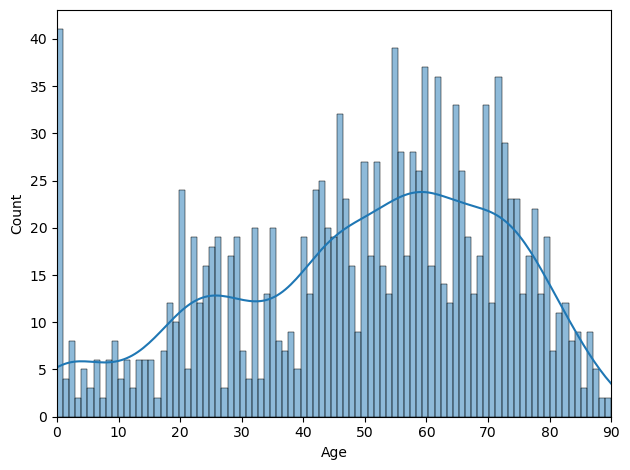

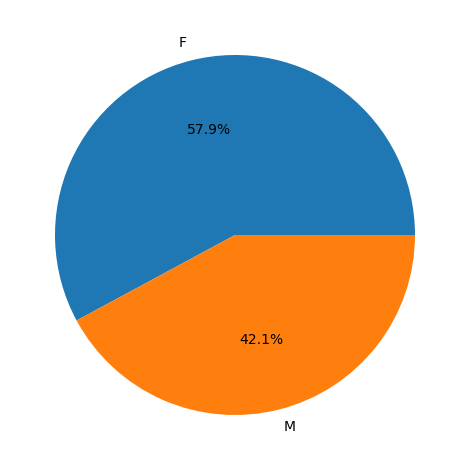

F:\softwares\ana\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
F:\softwares\ana\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


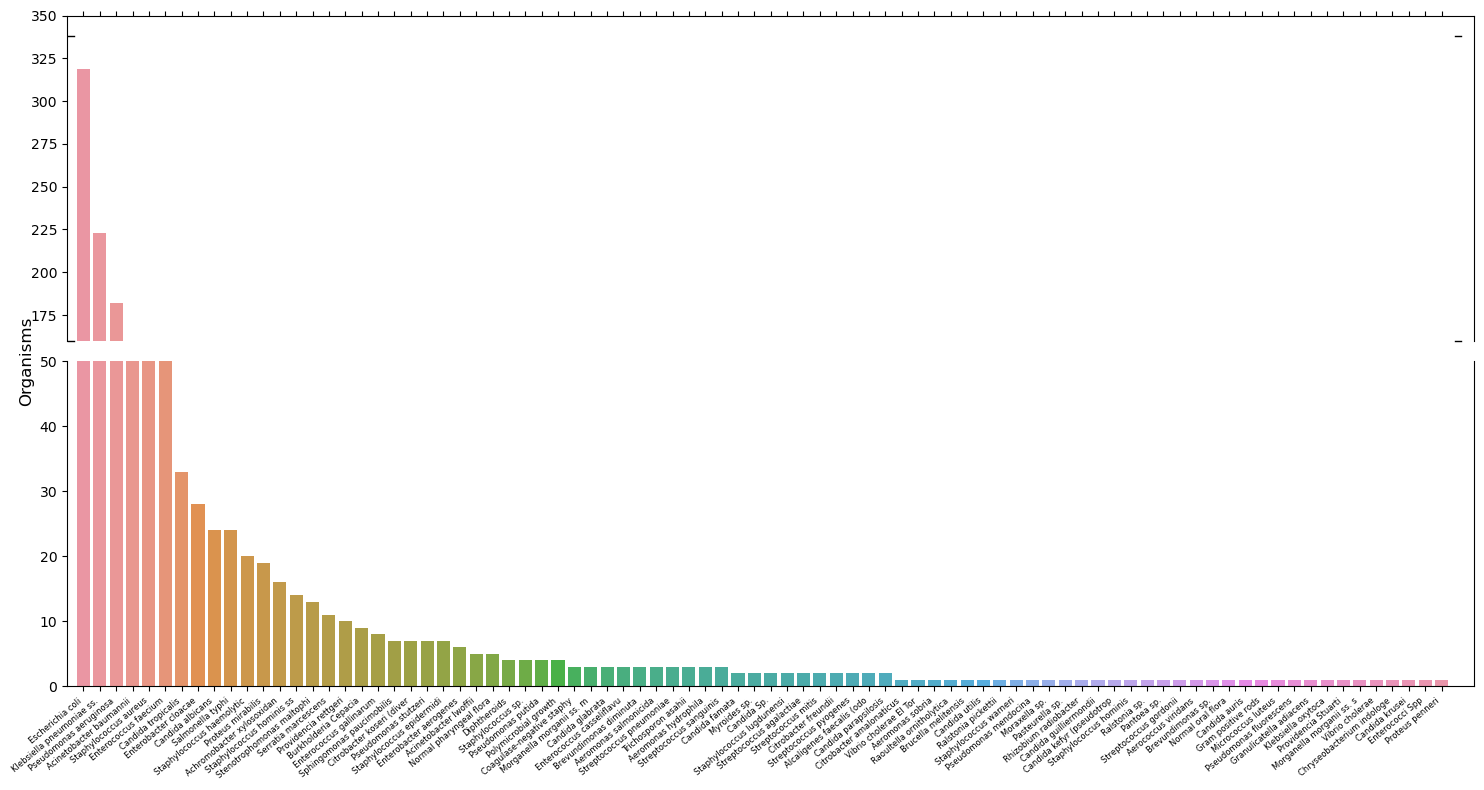

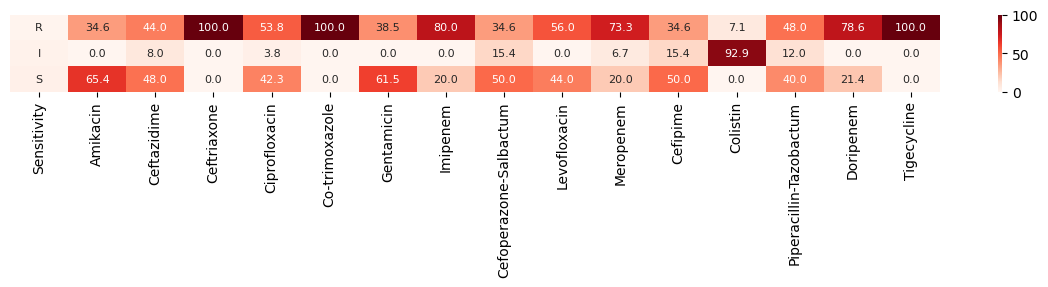

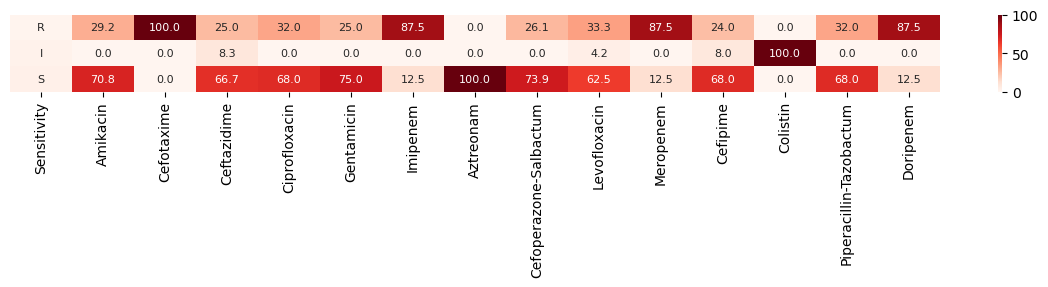

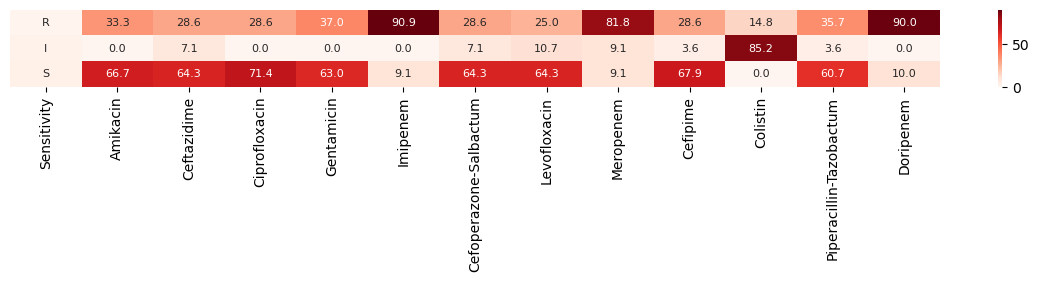

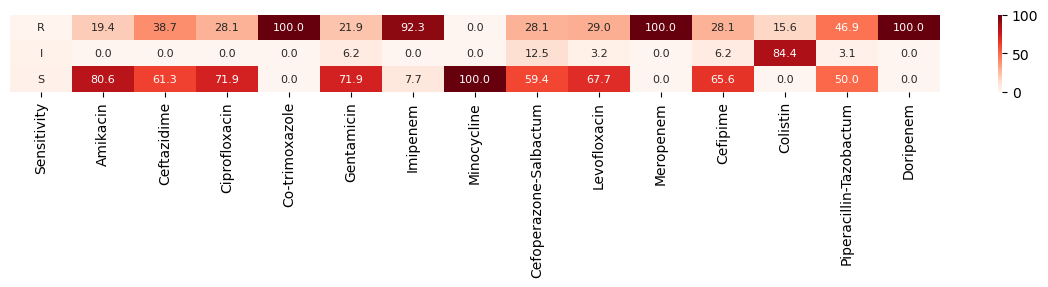

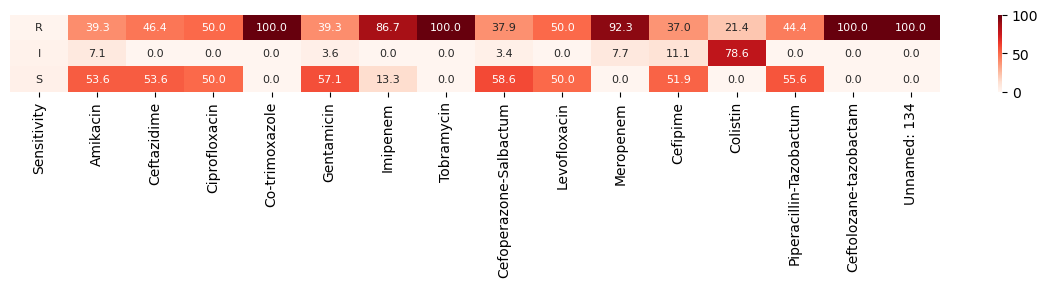

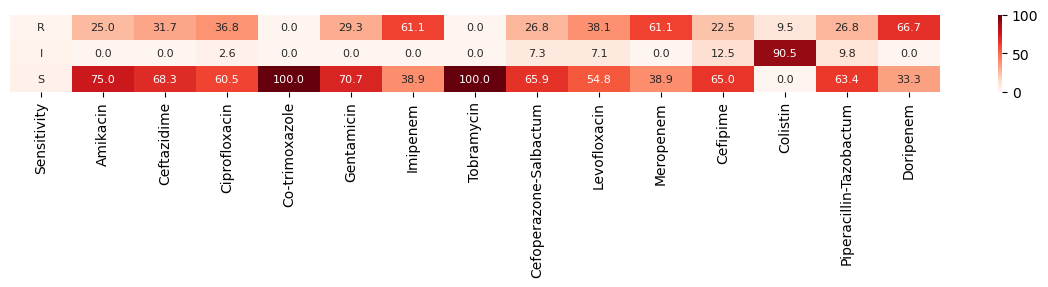

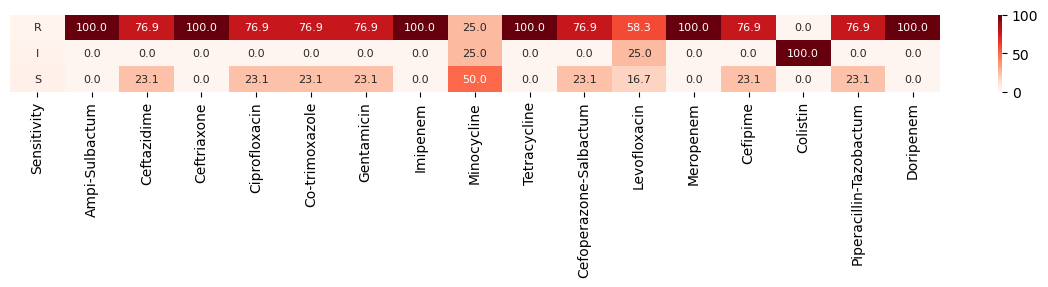

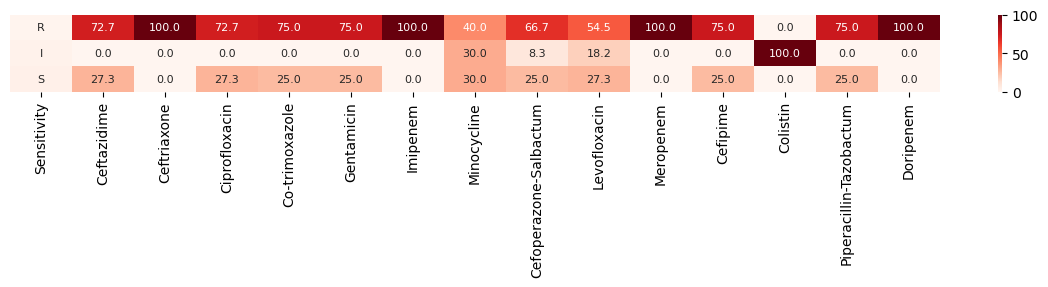

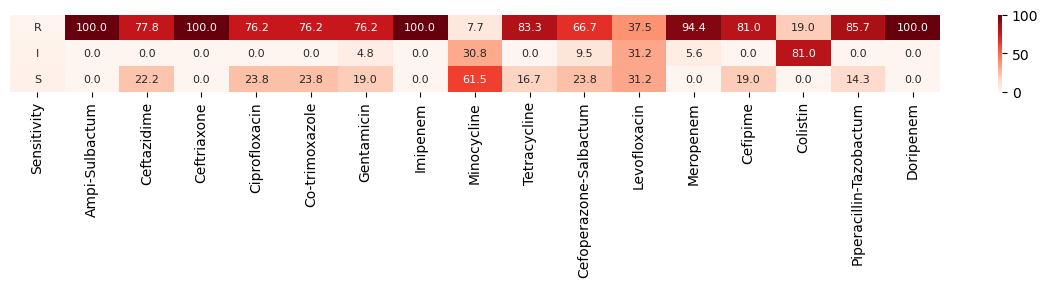

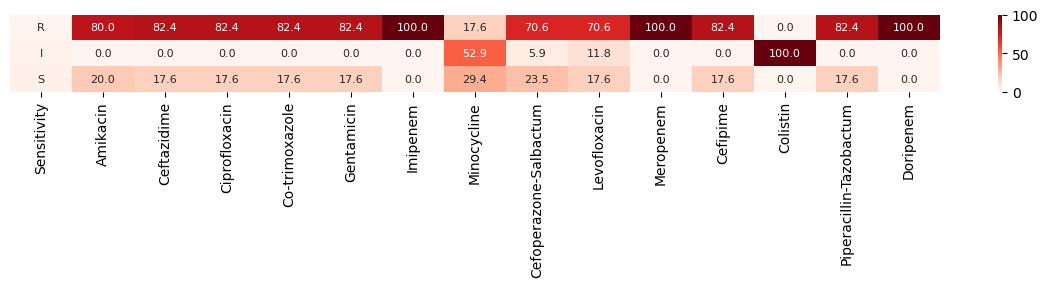

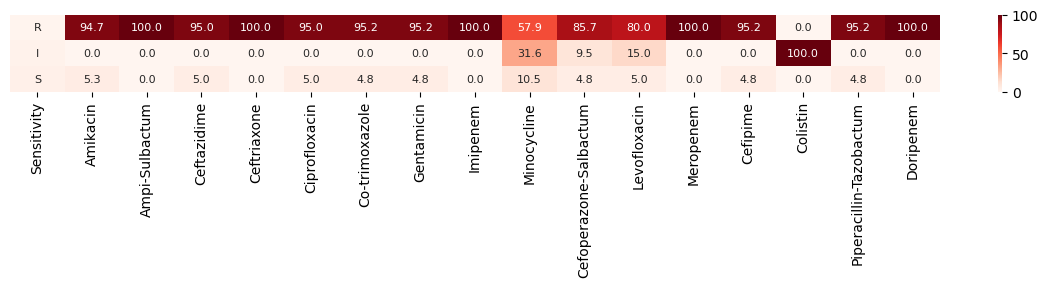

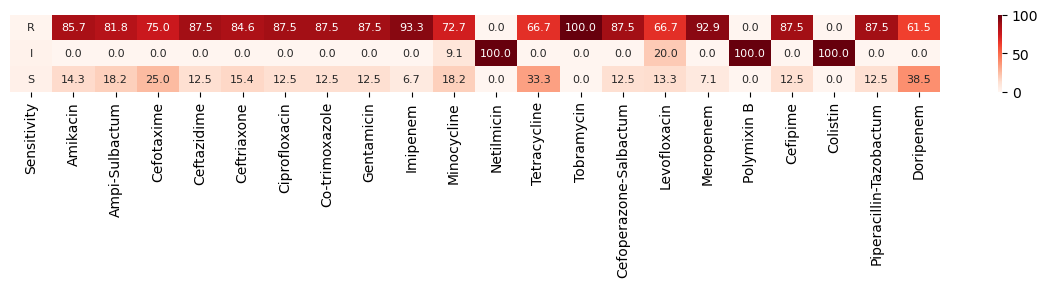

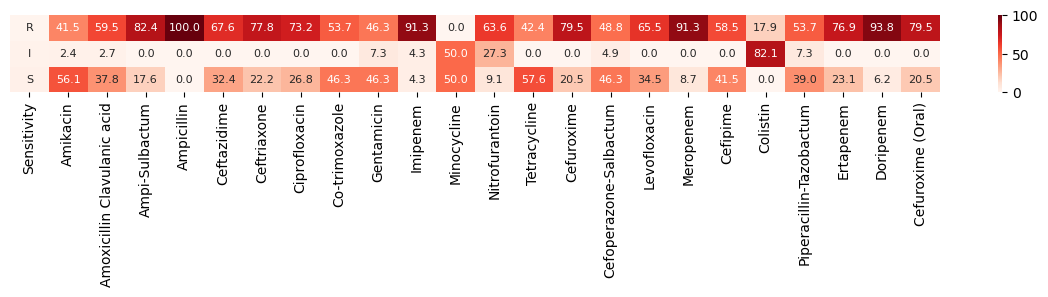

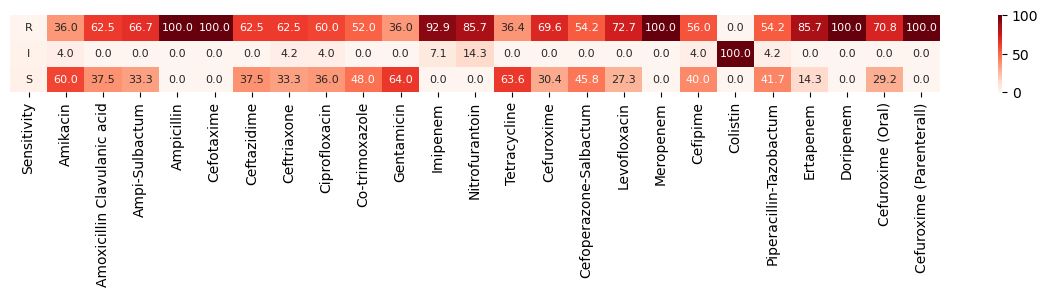

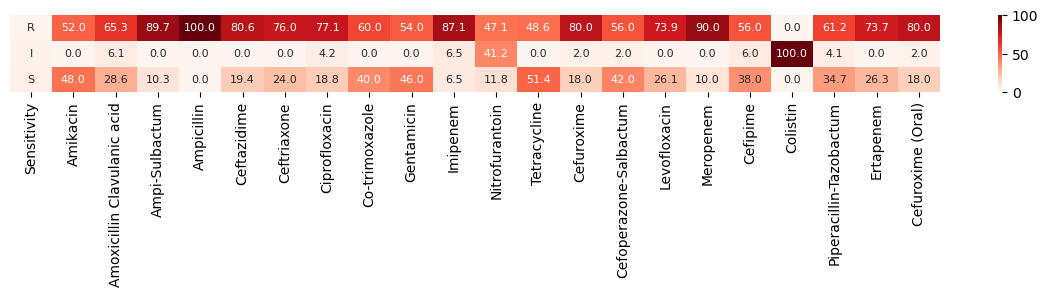

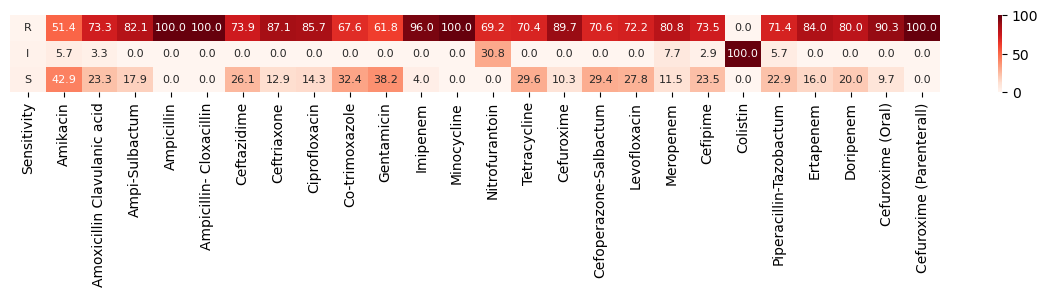

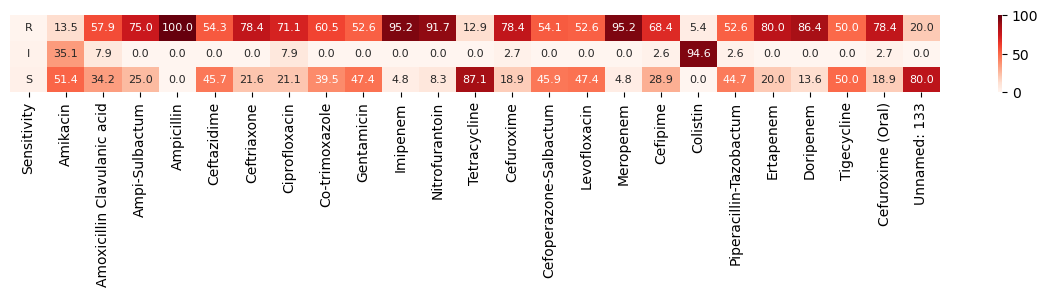

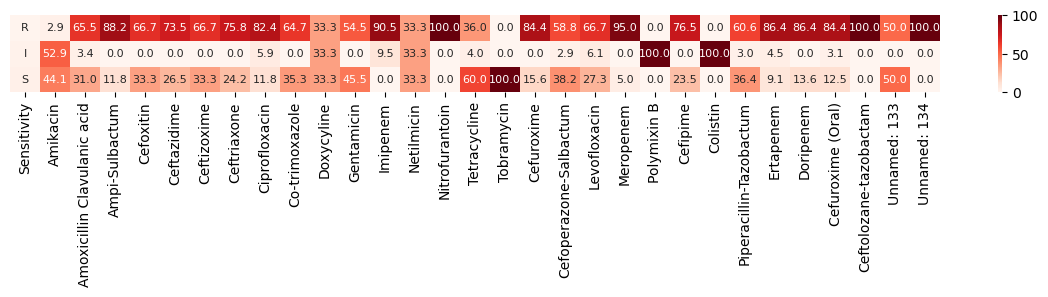

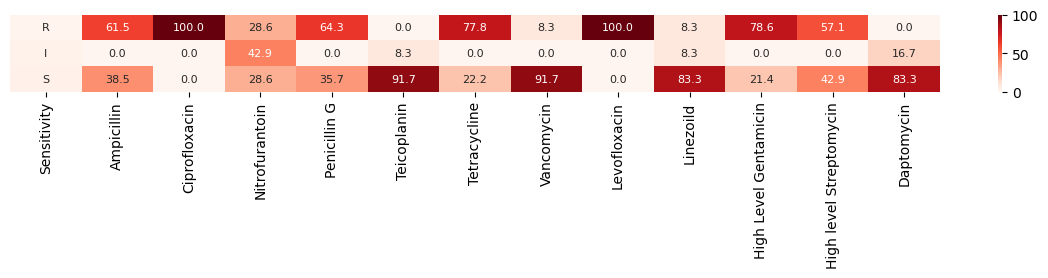

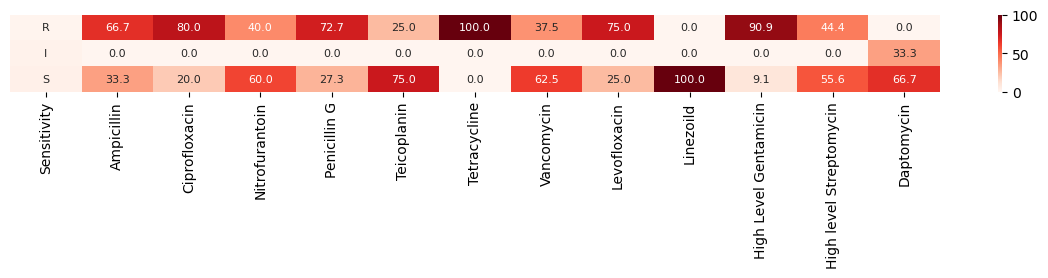

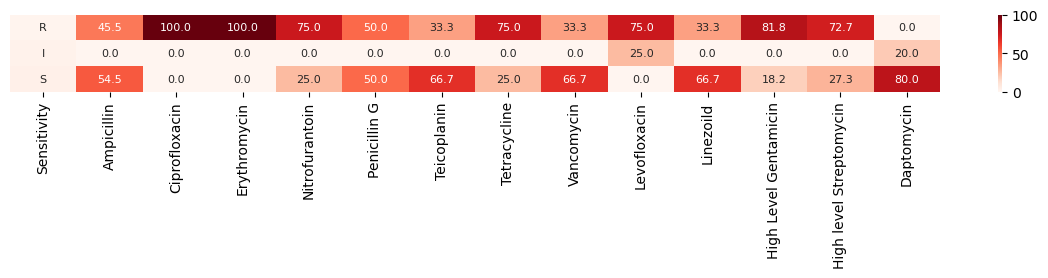

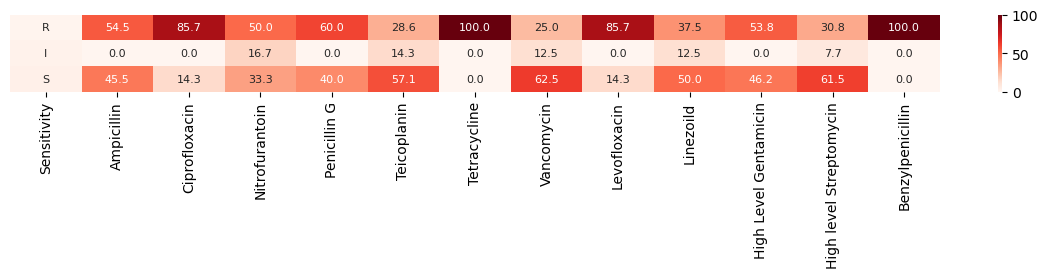

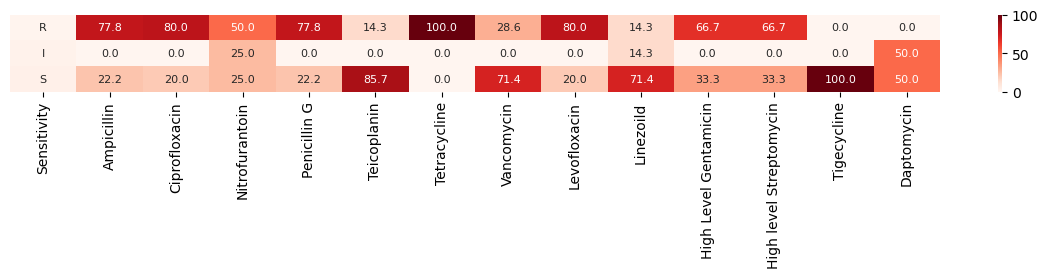

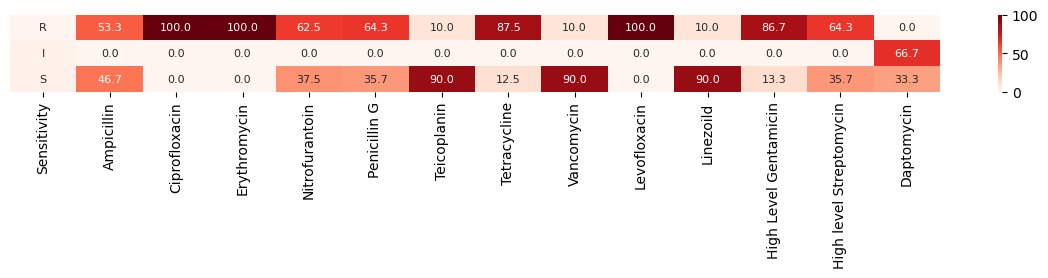

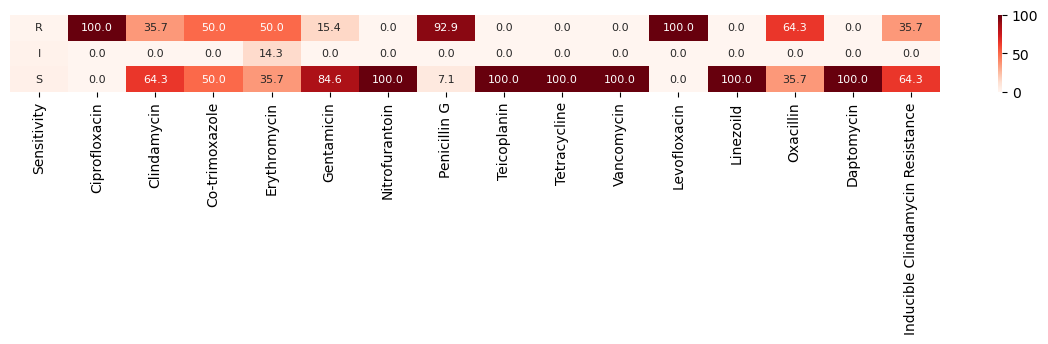

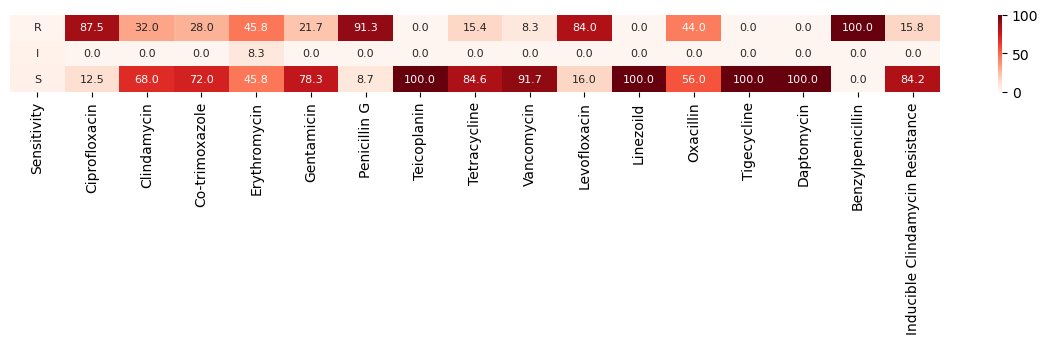

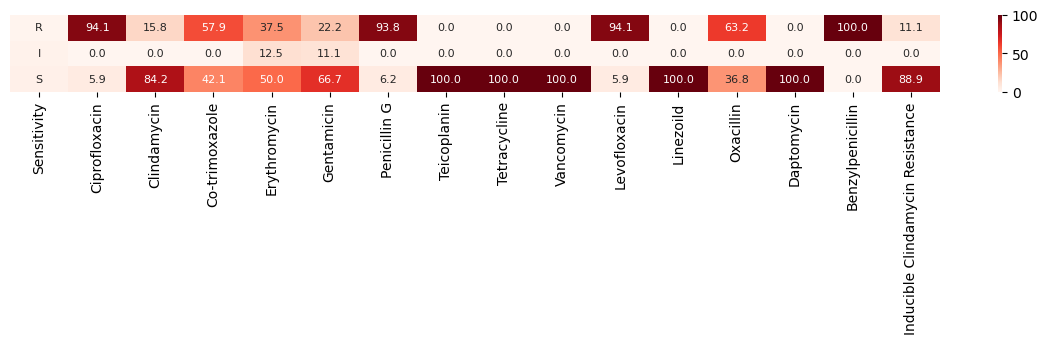

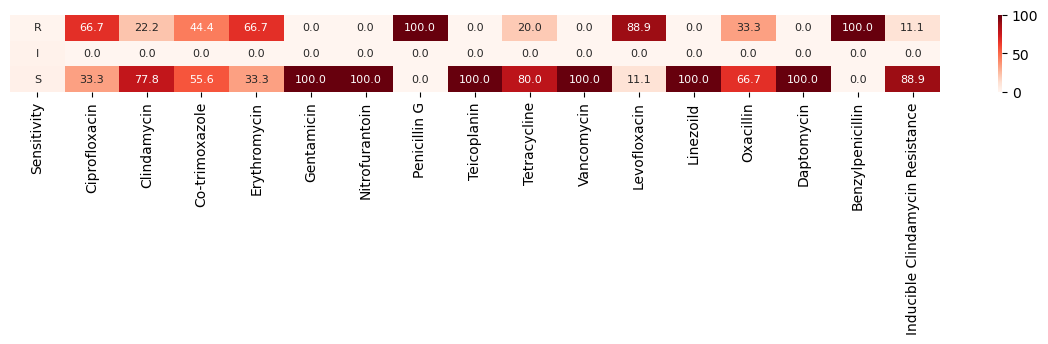

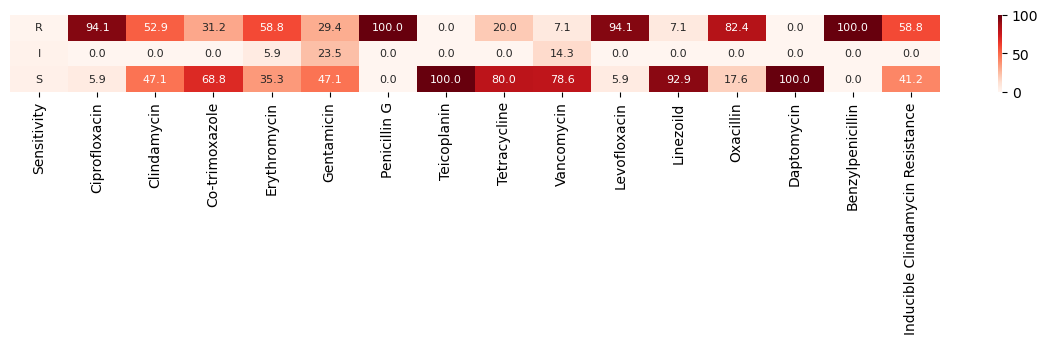

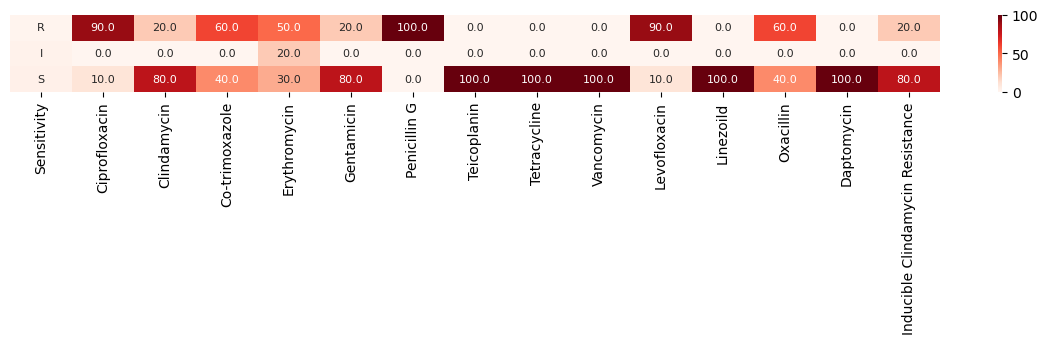

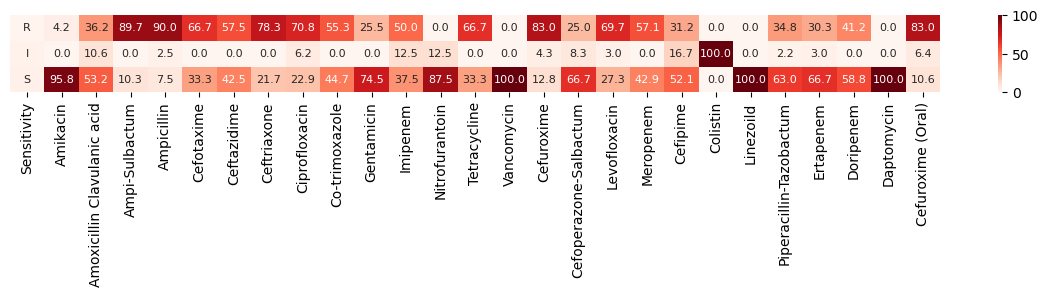

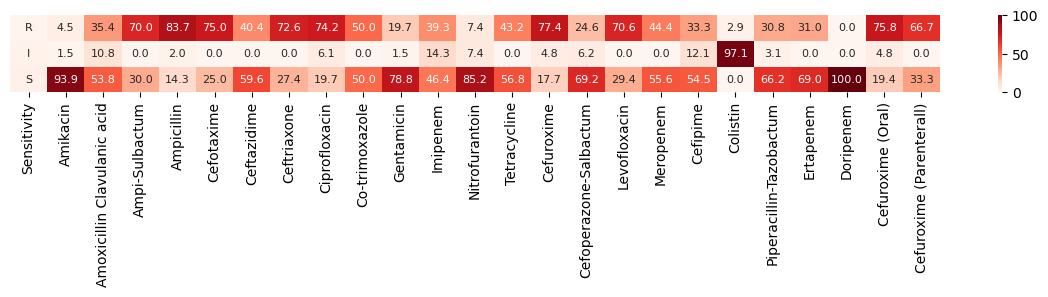

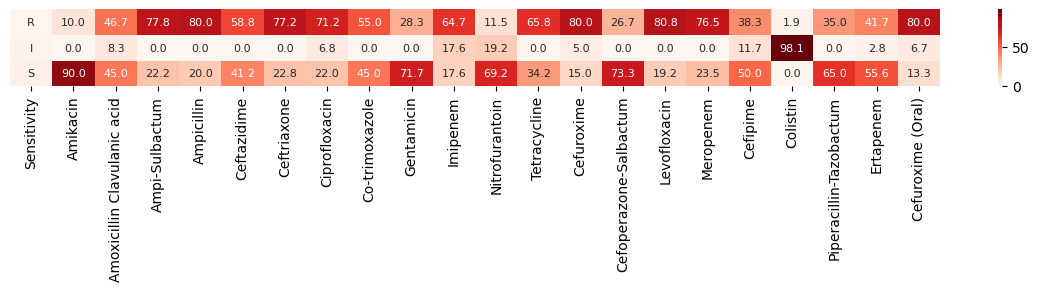

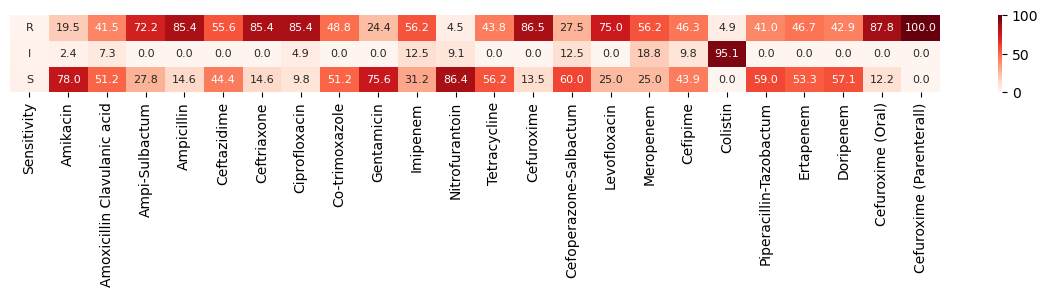

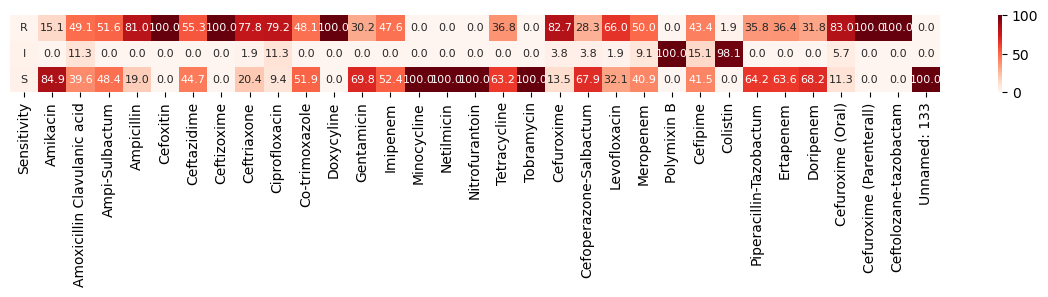

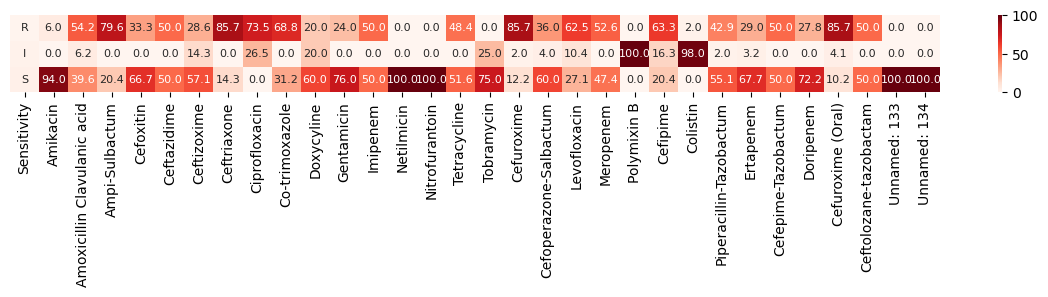

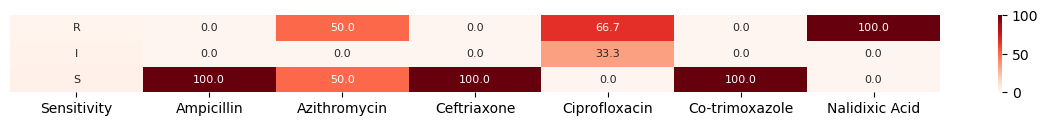

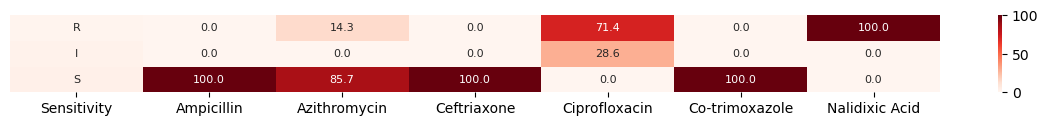

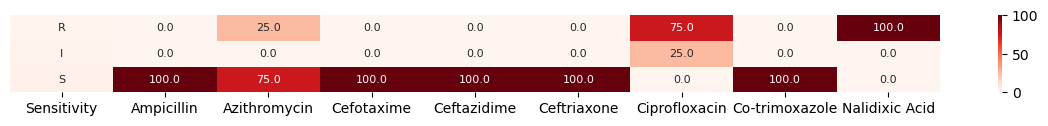

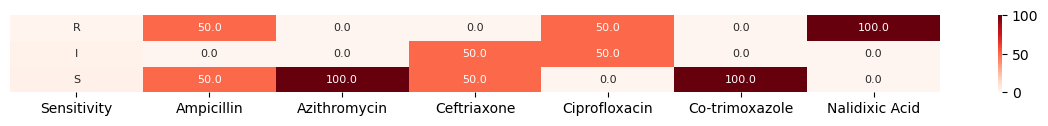

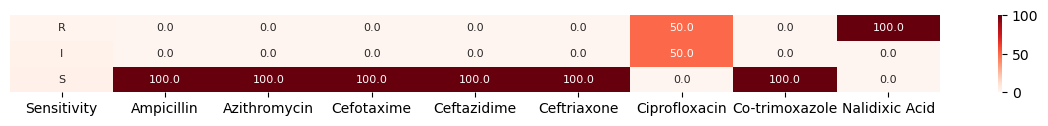

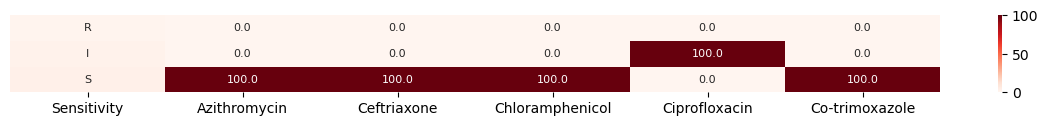

In [306]:
file_name = 'AMR 22.6.22.csv'
df = load(file_name)
df = clean(df)
df = remove(df)
info(df)

organisms = ['Pseudomonas aeruginosa','Acinetobacter baumannii','Klebsiella pneumoniae ss.',
            'Enterococcus faecium','Staphylococcus aureus','Escherichia coli', ]


for i in organisms:
    sample(df,i)
    ResistanceHeatmap(df,i,'May')
    ResistanceHeatmap(df,i,'June')
    ResistanceHeatmap(df,i,'July')
    ResistanceHeatmap(df,i,'August')
    ResistanceHeatmap(df,i,'September')
    ResistanceHeatmap(df,i,'October')